# Exploratory Analysis
---

This code imports zipped data files from an S3 bucket, determines the shape and size of the data frame (Pandas), detects outliers/NAN/Null values, calculates collumn-wise mean/median/mode/stddev, and performs some correlation analysis on the variables.

# Dependencies & Functions
---

In [2]:
import pandas as pd
import boto3
import botocore
import sagemaker
import numpy as np
from eda import eda
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle

#Globals
filename_prefix = 'attack_01_'    #Filename prefix, for storing artifacts
store_artifacts = False           #True will save figures, tables, and dataframes to 

# Input dataset filename name here
data_filename = "SWaT_Dataset_Attack_v1_01.parquet"

# Import Data
---

In [3]:
# Import dataset from S3 Bucket

bucket = "exploratoryanalysis-swat"             # Bucket location for working directory
prefix = "analysis_artifacts"                   # Folder location for working directory

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = "exploratoryanalysis-swat"    # Bucket location for data directory
downloaded_data_prefix = "dataset_unzipped"            # Folder location of data files

# Housekeeping, sagemaker gets execution role and reigon from this sagemaker instance
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Check bucket existence and permissions
def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}")
# Future development: expand for more data upload options, perhaps a filepath instead

Training input/output will be stored in: s3://exploratoryanalysis-swat/analysis_artifacts
Downloaded training data will be read from s3://exploratoryanalysis-swat/dataset_unzipped


# Classify & Organize
---

In [4]:
# Organize and qualify data

# Download S3 data file to Sagemaker space
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)

# Read file into Pandas Dataframe 
sensor_data = pd.read_parquet(data_filename)

# Establish Shape of raw sensor data
raw_data_shape = sensor_data.shape

# Clean Data
---

In [5]:
# Locate NAN values and store indicies
nan_values = sensor_data[sensor_data.isna().any(axis=1)]
if nan_values.empty:
    pass
else:
    # Determine what we want to do with the missing fields
    print('There are NAN values in the data')

In [6]:
# -----------------------------THIS SECTION CAN BE REMOVED ONCE ALL FILES ARE THOROUGHLY CLEANED ------------------#
# The files last column is labled Normal/Attack and will now just be called "Attack" with a boolean true/false instead of strings

sensor_data = sensor_data.rename(columns={"Normal/Attack": "Attack"})
sensor_data['Attack'] = sensor_data['Attack'].map({'Attack': True, 'Normal': False})

filename = data_filename
sensor_data.to_parquet(filename)

s3.upload_file(
    Filename=filename,
    Bucket=bucket,
    Key=f"{prefix}/{filename}"
)  

# Data Statistics
---

In [7]:
# Determine mean, median, std dev, etc. of each collumn
data_statistics = sensor_data.describe()
#print("Dataset statistics for each column:")
pd.set_option('display.max_columns', None)
display(data_statistics)

if store_artifacts == True:
    filename = filename_prefix + 'data_statistics.csv'
    data_statistics.to_csv(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
count,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.0,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.0,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.0,207582.000000,207582.0,207582.0,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.000000,207582.0,207582.000000,207582.000000,207582.000000,207582.000000,207582.0,207582.000000,207582.0
mean,1.847924,595.120456,1.716170,1.746948,1.009095,245.058583,8.432726,328.156156,1.832689,1.743263,1.043583,1.0,1.743393,1.000270,1.744352,1.000265,16.912496,1.847049,904.496100,1.008970,1.807777,1.025354,1.028659,1.0,1.831291,148.806436,153.124521,1.712964,882.349618,1.0,1.999976,1.0,1.0,1.995038,7.835533,144.499134,265.126982,13.601093,1.726948,1.287280,0.731598,0.305617,1.995057,1.0,248.884792,1.282580,187.797817,0.017922,1.0,1.009803,1.0
std,1.133944,113.610881,0.463293,0.434761,0.094934,18.842447,0.094010,6.055341,1.064779,0.446293,0.204165,0.0,0.436762,0.016423,0.436226,0.016275,7.085444,0.805882,74.043844,0.131715,0.412072,0.188803,0.207672,0.0,0.374496,0.003624,7.630425,0.097010,74.263395,0.0,0.004908,0.0,0.0,0.070266,0.035038,5.773174,5.869959,10.575782,0.036403,0.035838,0.027806,0.021580,0.070130,0.0,6.221712,0.335182,4.101873,0.165609,0.0,0.098526,0.0
min,0.000000,434.881300,0.000000,1.000000,1.000000,199.788500,6.000000,310.100000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.006402,0.000000,580.362700,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,148.759900,145.706200,0.000000,572.622400,1.0,1.000000,1.0,1.0,1.000000,7.757498,139.374500,254.293800,9.536016,1.206101,0.801332,0.333771,0.000000,1.000000,1.0,163.884300,0.000000,134.468700,0.000000,1.0,1.000000,1.0
25%,0.000000,509.343800,1.000000,1.000000,1.000000,229.236100,8.385862,323.891300,0.040560,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,19.508290,2.202863,833.680500,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.803200,151.422700,1.710954,835.362700,1.0,2.000000,1.0,1.0,2.000000,7.812292,143.322200,260.446000,12.227630,1.720200,1.276419,0.730916,0.306569,2.000000,1.0,247.580700,0.961138,186.634800,0.000000,1.0,1.000000,1.0
50%,2.497518,527.792600,2.000000,2.000000,1.000000,257.882600,8.427198,330.299900,2.445391,2.000000,1.000000,1.0,2.000000,1.000000,2.000000,1.000000,19.767590,2.207347,918.033900,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.808000,153.037700,1.719412,889.464200,1.0,2.000000,1.0,1.0,2.000000,7.847539,144.270700,263.746500,12.881310,1.730069,1.290637,0.734116,0.306761,2.000000,1.0,249.519300,1.425688,188.253000,0.000128,1.0,1.000000,1.0
75%,2.585274,692.030750,2.000000,2.000000,1.000000,259.741100,8.475584,332.786500,2.451158,2.000000,1.000000,1.0,2.000000,1.000000,2.000000,1.000000,19.956460,2.211575,967.179900,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.808000,154.037400,1.727357,937.836400,1.0,2.000000,1.0,1.0,2.000000,7.854589,145.039700,268.969500,13.804150,1.737760,1.302037,0.735397,0.308362,2.000000,1.0,250.993300,1.569859,189.502700,0.000128,1.0,1.000000,1.0
max,2.706659,925.032300,2.000000,2.000000,2.000000,267.719800,8.600872,340.169200,2.823695,2.000000,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,45.000000,2.353265,1200.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,148.856100,297.385300,1.744914,1002.128000,1.0,2.000000,1.0,1.0,2.000000,8.225006,272.853100,291.015100,255.000000

In [ ]:
# What are the unique values and counts for each categorical column
unique_values = sensor_data.nunique(axis=0)
#display(unique_values)

if store_artifacts == True:
    filename = filename_prefix + 'unique_values_count.csv'
    unique_values.to_csv(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

# Which columns have only a single unique value? (Constants)
constant_columns = unique_values.where(unique_values==1).dropna(how='all')
display(constant_columns)

if store_artifacts == True:
    filename = filename_prefix + 'constant_values.csv'
    constant_columns.to_csv(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

In [ ]:
# Exploratory Data Analysis Function
eda(df=sensor_data)

# Outliers
---

In [ ]:
# Locate and classify outliers
import numpy as np
from scipy import stats

# The collumns include two objects: a timestamp and a string. These cannot be analyzed for outliers, and will be removed by selecting only columns with numbers
numerical_sensor_data = sensor_data.select_dtypes(include='number')

# Z Score tells us how many standard deviations each value is from the mean. Anything outside of 3 STD deviations is an outlier and anything outside 2 is in the farthest 5% and could be cut
z_scores = numerical_sensor_data.apply(stats.zscore)

pd.set_option('display.max_columns', None)
#display(z_scores.head())

if store_artifacts == True:
    filename = filename_prefix + 'z_scores_matrix.parquet'
    z_scores.to_parquet(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

In [ ]:
# Interquartile Range (IQR) is another way to classify outliers. 
# IQR determines the range between the 25th and 75th percentile
# Then, anything that lies 1.5*(range) above or below these quartiles is considered an outlier
# If the data value is lower than the lower range or larger than the upper range, store the index of the value.
# Then count the number of outliers

IQR = data_statistics.loc['75%'] - data_statistics.loc['25%']
IQR = IQR.to_frame()
IQR = IQR.transpose()

# Define lower and upper ranges for each variable. Statistics does not run on timestamp or string objects. Only columns with numerical values.
lower_range = data_statistics.loc['25%'] - 1.5 * IQR
upper_range = data_statistics.loc['75%'] + 1.5 * IQR

# The format of a query needs to be "column label <query condition> @<variable name to be compared against>"
# 'FIT101<@aa' where aa is the variable that holds the limit value for this iteration
lower_queries = ['{}<@aa'.format(k) for k in lower_range.columns]
upper_queries = ['{}>@aa'.format(k) for k in upper_range.columns]

jj = 0
tot_upper_outl = 0
tot_lower_outl = 0
for column in IQR:
    # Lower boundary check
    aa = lower_range.iat[0,jj]                                        # ex: FIT101
    lower_outliers = numerical_sensor_data.query(lower_queries[jj])   # ex: 'FIT101<@aa'
    if not lower_outliers.empty:
        print('Condition that triggered the IQR outlier: ', lower_queries[jj], aa)
        print('Number of "less than" outliers', lower_outliers.shape[0], '\n')
        tot_lower_outl += lower_outliers.shape[0]
    
    # Upper Boundary Check
    aa = upper_range.iat[0,jj]                                        # ex: FIT101
    upper_outliers = numerical_sensor_data.query(upper_queries[jj])   # ex: 'FIT101>@aa'
    if not upper_outliers.empty:
        print('Condition that triggered the IQR outlier: ', upper_queries[jj], aa)
        print('Number of "greater than" outliers', upper_outliers.shape[0], '\n')
        tot_upper_outl += upper_outliers.shape[0]
    jj += 1
    
#print('Total number of outliers: ', tot_lower_outl+tot_upper_outl)

if store_artifacts == True:
    filename = filename_prefix + 'lower_IQR_outliers.parquet'
    lower_outliers.to_parquet(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )
    
    filename = filename_prefix + 'upper_IQR_outliers.parquet'
    upper_outliers.to_parquet(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

# Correlation
---

In [12]:
# Correlation analysis
# Are there any correlations between the different columns in the data?
# Display correlation matrix

# First, drop all the columns with constant values. These will not impact a correlation matrix.
variable_sensor_data = sensor_data.drop(constant_columns.index, axis=1)

correlation_matrix = variable_sensor_data.corr()
pd.set_option('display.max_columns', None)
#display(correlation_matrix.head())

# Upload correlation matrix CSV to S3 Artifacts
if store_artifacts == True:
    filename = filename_prefix + 'correlation_matrix.csv'
    correlation_matrix.to_csv(filename)

    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

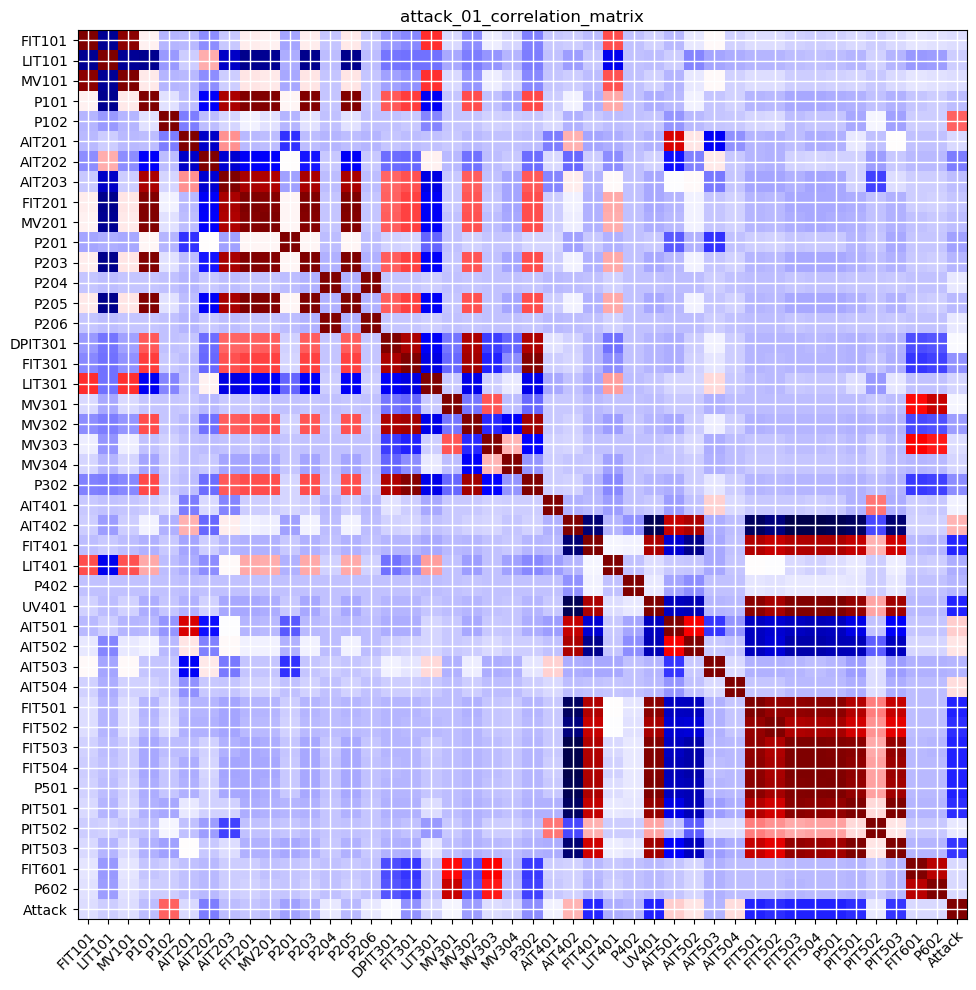

In [13]:
# Plot the correlation matrix
fig, ax = plt.subplots()

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(correlation_matrix)));
ax.set_yticks(np.arange(len(correlation_matrix)));
ax.minorticks_off()
ax.grid(which='major', 
        color='white', 
        linestyle='-', 
        linewidth=1, 
        visible=True);
ax.set_xticklabels(correlation_matrix.columns);
ax.set_yticklabels(correlation_matrix.index);

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor");

title = filename_prefix + "correlation_matrix"

ax.set_title(title)
fig.set_figwidth(10);
fig.set_figheight(10);
fig.tight_layout();
im = ax.imshow(correlation_matrix, cmap='seismic');

plt.show()

if store_artifacts == True:
    filename = title + '.png'
    plt.savefig(filename)
    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

# Plots

In [ ]:
# Box Plot
# We need to decide which values box plots are appropriate for. Numerical data with sufficient variation (not a binary 1 or 0)
import matplotlib.pyplot as plt

flierprops = dict(marker='*',
                  markeredgecolor='red',
                  markersize=2,
                  linestyle='none');

# ------------------------------------------------------------------------------ #
fig1, ax1 = plt.subplots();
ax1.set_title(filename_prefix + 'Tank Levels');

ax1.boxplot([sensor_data.LIT101, sensor_data.LIT301, sensor_data.LIT401],
            showmeans=True,
            flierprops=flierprops);
ax1.set_xticklabels(['LIT101','LIT301','LIT401']);
fig1.set_figwidth(10);
fig1.set_figheight(10);
plt.show(fig1)

# ------------------------------------------------------------------------------ #
fig2, ax2 = plt.subplots()
ax2.set_title(filename_prefix + 'Chemistry Sensors');
ax2.boxplot([sensor_data.AIT201, sensor_data.AIT202, sensor_data.AIT203,
            sensor_data.AIT401, sensor_data.AIT402, sensor_data.AIT501,
            sensor_data.AIT502, sensor_data.AIT503, sensor_data.AIT504], 
            showmeans=True, 
            flierprops=flierprops)
ax2.set_xticklabels(['AIT201','AIT202','AIT203',
                    'AIT401','AIT402','AIT501',
                    'AIT502','AIT503','AIT504'])
fig2.set_figwidth(10);
fig2.set_figheight(10);
plt.show(fig2)

# ------------------------------------------------------------------------------ #
fig3, ax3 = plt.subplots()
ax3.set_title(filename_prefix + 'Flow Meters');
ax3.boxplot([sensor_data.FIT101, sensor_data.FIT201, sensor_data.FIT301,
            sensor_data.FIT401, sensor_data.FIT501, sensor_data.FIT502,
            sensor_data.FIT503, sensor_data.FIT504, sensor_data.FIT601], 
            showmeans=True, 
            flierprops=flierprops)
ax3.set_xticklabels(['FIT101','FIT201','FIT301',
                    'FIT401','FIT501','FIT502',
                    'FIT503','FIT504','FIT601'])
fig3.set_figwidth(10);
fig3.set_figheight(10);
plt.show(fig3)

# ------------------------------------------------------------------------------ #
fig4, ax4 = plt.subplots()
ax4.set_title(filename_prefix + 'Chemistry Sensors');
ax4.boxplot([sensor_data.AIT501, 
            sensor_data.AIT504], 
            showmeans=True, 
            flierprops=flierprops)
ax4.set_xticklabels(['AIT501',
                    'AIT504'])
fig4.set_figwidth(10);
fig4.set_figheight(10);
plt.show(fig4)


In [ ]:
# Plot time-series data for visual representation

attack_data = sensor_data.query('Attack==True')
normal_data = sensor_data.query('Attack==False')

#This helps rendering speed at the cost of fuzzy graphs
mplstyle.use('fast')
n_points = 2000

title = filename_prefix + "instert title"

fig1, ax1 = plt.subplots();
plt.plot(normal_data.Timestamp.loc[1:n_points], normal_data.AIT402.loc[1:n_points], 'g-');
plt.plot(attack_data.Timestamp.loc[1:n_points], attack_data.AIT402.loc[1:n_points], 'r-');
ax1.set_title(filename_prefix + 'Tank Levels');
fig1.set_figwidth(10);
fig1.set_figheight(10);

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

if store_artifacts == True:
    filename = title + '.png'
    plt.savefig(filename)
    s3.upload_file(
        Filename=filename,
        Bucket=bucket,
        Key=f"{prefix}/{filename}"
    )

In [ ]:
for ii in normal_data.columns:
    fig, ax = plt.subplots();
    plt.plot(normal_data..loc[1:n_points], normal_data.AIT402.loc[1:n_points], 'g-')